# **OBTENDO OS DADOS**

## Configuração


In [1173]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# Common imports
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


## Obtendo os dados

In [1174]:
import os
import requests
import zipfile
import pandas as pd

url = "https://www.kaggle.com/api/v1/datasets/download/joebeachcapital/30000-spotify-songs"
zip_path = "spotify_songs.zip"
extract_path = "./datasets"
#create dataframe songs:


# Faz o download do arquivo zip
response = requests.get(url)
with open(zip_path, "wb") as file:
    file.write(response.content)
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

## Conferindo rapidamente o dataset

In [1175]:
csv_path = os.path.join(extract_path, "spotify_songs.csv")
songs = pd.read_csv(csv_path)
print(songs.head())

                 track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   
1  0r7CVbZTWZgbTCYdfa2P31                    Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l                    All the Time - Don Diablo Remix   
3  75FpbthrwQmzHlBJLuGdC7                  Call You Mine - Keanu Silva Remix   
4  1e8PAfcKUYoKkxPhrHqw4x            Someone You Loved - Future Humans Remix   

       track_artist  track_popularity          track_album_id  \
0        Ed Sheeran                66  2oCs0DGTsRO98Gh5ZSl2Cx   
1          Maroon 5                67  63rPSO264uRjW1X5E6cWv6   
2      Zara Larsson                70  1HoSmj2eLcsrR0vE9gThr4   
3  The Chainsmokers                60  1nqYsOef1yKKuGOVchbsk6   
4     Lewis Capaldi                69  7m7vv9wlQ4i0LFuJiE2zsQ   

                                    track_album_name track_album_release_date  \
0  I Don't Care (with Justin Bieber) [Loud Luxu

In [1176]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

In [1177]:
pd.set_option('display.max_rows', None)
songs["playlist_genre"].value_counts()

,count
playlist_genre,
edm,6043
rap,5746
pop,5507
r&b,5431
latin,5155
rock,4951


# **PREPARANDO OS DADOS**

##Definição das **Funções para tratamento dos dados**.

In [1178]:
# REMOÇÃO DE DUPLICATAS - remove músicas repetidas

def removeDuplicates(df):
    # Adiciona uma coluna auxiliar com o nome da música em lowercase
    df['track_name_lower'] = df['track_name'].str.lower()
    # Remove duplicadas usando a coluna auxiliar
    df_unique = df.drop_duplicates(subset=['track_artist', 'track_name_lower'])
    # Remove a coluna auxiliar antes de retornar
    df_unique = df_unique.drop(columns=['track_name_lower'])
    return df_unique

In [1179]:
# ONEHOT DE ARTITAS MAIS RELEVANTES - Já que o dataset possue uma quantidade consideravel de artistas, faz o Onehot apenas dos artistas mais populares.

def onehotTopArtists(df, n, alpha=5):
    # Verifica se as colunas necessárias existem no DataFrame
    if 'track_artist' not in df.columns or 'track_popularity' not in df.columns:
        raise ValueError("O dataset deve conter as colunas 'track_artist' e 'track_popularity'.")
    # Calcula a popularidade total por artista
    artist_total_popularity = df.groupby('track_artist')['track_popularity'].sum()
    # Conta o número de músicas por artista
    artist_song_count = df.groupby('track_artist').size()
    # Ajuste da popularidade considerando o número de músicas com o parâmetro de suavização alpha
    artist_adjusted_popularity = artist_total_popularity / (artist_song_count + alpha)
    # Seleciona os `n` artistas mais populares com a popularidade ajustada
    top_artists = artist_adjusted_popularity.sort_values(ascending=False).head(n).index.tolist()
    print("Top artistas:", top_artists)  # Verifique os artistas mais populares
    # Cria colunas one-hot para esses `n` artistas mais populares
    for artist in top_artists:
        df[f"artist_{artist}"] = (df['track_artist'] == artist).astype(int)
    return df

In [1180]:
# REMOÇÃO DE COLUNAS - Remove colunas não úteis para a predição.

def removeColumns(df, columns_name):
    return df.drop(columns=columns_name)

In [1181]:
# REMOÇÃO DE LINHAS - Remove linhas que possuem dados em branco e que não podem ser obtidos por meio de outros dados.

#Utilizar depois de remover as colunas que não serão necessárias para a predição do modelo.
def removeRowNaN(songs_cp):
    songs_cp_sem_nulos = songs_cp.dropna(axis=0, how='any')
    return songs_cp_sem_nulos

def dropRowsEmpty(songs_cp):
    songs_cp_sem_nulos = removeRowNaN(songs_cp)
    valores_nulos_por_coluna = songs_cp_sem_nulos.isna().sum()
    songs_cp = songs_cp_sem_nulos
    return songs_cp


In [1182]:
# NORMALIZAÇÃO DE DADOS NUMÉRICOS

#Normaliza os dados numa escala de 0 a 1.
def normalizeColumns(df,columns_name):
    scaler = MinMaxScaler()
    df[columns_name] = scaler.fit_transform(df[columns_name])
    return df

In [1183]:
# ONEHOT para as variáveis categóricas que possuem um número pequeno de categorias.

def onehotEncode(df, columns):
    pd.get_dummies(df, columns=columns, prefix=columns)

In [1184]:
# PREENCHE MẼS DE LANÇAMENTO DAS MÚSICAS QUE NÃO POSSUEM ESSE DADO.

def fillMonths(songs: pd.DataFrame) -> pd.DataFrame:
    # Criar uma cópia do DataFrame para evitar modificar o original
    df = songs.copy()

    # Filtrar as linhas onde a data de lançamento tem apenas o ano (4 caracteres)
    df_ano_apenas = df[df['track_album_release_date'].str.len() == 4].copy()

    # Filtrar as linhas onde a data de lançamento tem o formato completo (ano-mês-dia)
    df_completo = df[df['track_album_release_date'].str.len() == 10].copy()

    # Extrair o mês das músicas com ano-mês-dia
    df_completo['month'] = df_completo['track_album_release_date'].str[5:7]

    # Contar a frequência de cada mês
    month_counts = df_completo['month'].value_counts()

    # Agora vamos preencher os meses nas músicas com ano apenas, de forma proporcional
    # Criação de uma lista que vai armazenar os meses a serem atribuídos
    months_to_fill = []

    # Para cada mês na distribuição, vamos adicionar o mês de forma proporcional
    for month, count in month_counts.items():
        months_to_fill.extend([month] * count)

    # Para as músicas faltando mês, vamos preencher com base na lista 'months_to_fill'
    df_ano_apenas['month'] = np.random.choice(months_to_fill, size=len(df_ano_apenas))

    # Agora vamos juntar os dois DataFrames (completo e preenchido) novamente
    # Garantindo que estamos mantendo todas as colunas, não apenas 'track_album_release_date'
    df_completo['month'] = df_completo['month']  # As músicas já completas não devem ser modificadas
    df_ano_apenas['track_album_release_date'] = df_ano_apenas['track_album_release_date'] + '-' + df_ano_apenas['month'] + '-01'

    # Substituir as linhas no DataFrame copiado
    df.update(df_completo)  # Atualiza as músicas completas
    df.update(df_ano_apenas)  # Atualiza as músicas com ano apenas

    # Retornar o DataFrame alterado
    return df

In [1185]:
# DECOMPÕE A COLUNA 'track_album_release_date' EM 'track_year' E 'track_month'.

def decompositionDateTransform(df, date_column):
    # Como o ano é composto de 4 dígitos, iremos extrair os 4 primeiros caracteres da coluna
    def get_year(date):
        if isinstance(date, str) and len(date) >= 4 and date[:4].isdigit():
            return int(date[:4])
        return None

    # Depois dos 4 caracteres teremos um '-' que faz a divisão do ano e mês, iremos fazer
    # split e pegaremos os dois próximos dígitos
    def get_month(date):
        if isinstance(date, str) and len(date) >= 7:
            parts = date.split('-')
            if len(parts) > 1 and parts[1].isdigit():
                return f"{int(parts[1]):02d}"  # Garantir dois dígitos no mês
        return None

    # Agora adicionamos as novas colunas
    df['track_year'] = df[date_column].apply(get_year)
    df['track_month'] = df[date_column].apply(get_month)
    return df

In [1186]:
# DECOMPÕE 'duration_ms' EM 'track_minutes' E 'track_seconds'.

def MilisecondsTransform(df, millis_column):
    def get_minutes(millis):
        if isinstance(millis, (int, float)) and millis >= 0:
            return millis // 60000
        return None

    def get_seconds(millis):
        if isinstance(millis, (int, float)) and millis >= 0:
            return (millis % 60000) // 1000
        return None

    df['track_minutes'] = df[millis_column].apply(get_minutes)
    df['track_seconds'] = df[millis_column].apply(get_seconds)
    return df

In [1187]:
# CLASSIFICA A COLUNA 'duration_ms' EM 0,1,2,3,4,5 e 6, NA COLUNA 'track_duration_classification'

def classifyDuration(df, millis_column):
    def classify(millis):
        if isinstance(millis, (int, float)) and millis >= 0:
            duration_minutes = millis / 60000
            if duration_minutes == 0:
                return 0
            elif duration_minutes <= 1:
                return 1
            elif duration_minutes <= 2:
                return 2
            elif duration_minutes <= 3:
                return 3
            elif duration_minutes <= 4:
                return 4
            elif duration_minutes <= 5:
                return 5
            else:
                return 6
        return None

    df['track_duration_classification'] = df[millis_column].apply(classify)
    return df

In [1188]:
# RETORNA OS DADOS DISCRETIZADOS E POSSÍVEIS OUTLIERS

def discretizeAndPossibleOutliers(data, n_bins=10, metodo='quantis'):
    if metodo == 'quantis':
        # Discretização baseada em quantis (divide os dados em n_bins intervalos com número igual de dados)
        bins = np.percentile(data, np.linspace(0, 100, n_bins+1))
        labels = [f'Intervalo {i+1}' for i in range(n_bins)]
        data_discretizada = pd.cut(data, bins=bins, labels=labels, include_lowest=True)
    elif metodo == 'igual':
        # Discretização por intervalos iguais (divide os dados em n_bins intervalos de tamanho igual)
        bins = np.linspace(data.min(), data.max(), n_bins+1)
        labels = [f'Intervalo {i+1}' for i in range(n_bins)]
        data_discretizada = pd.cut(data, bins=bins, labels=labels, include_lowest=True)
    else:
        raise ValueError("ERROR: 'quantis' ou 'igual'.")

    # Visualizar os dados discretizados
    sns.histplot(data_discretizada, kde=False, discrete=True, color='skyblue')
    plt.title('Distribuição dos Dados Discretizados')
    plt.xlabel('I')
    plt.ylabel('C')
    plt.show()

    # Identificar outliers (valores fora de 1.5 vezes o intervalo interquartil)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    outliers = data[(data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))]

    return data_discretizada, outliers

In [1189]:
# ONEHOT do gênero das músicas


def oneHotGenre(df):

  # Aplicar One-Hot Encoding e modificar os nomes das colunas
  one_hot = pd.get_dummies(df['playlist_genre'], prefix='track_genre')

  # Garantir que os valores sejam inteiros (0 ou 1)
  one_hot = one_hot.astype(int)

  # Concatenar o resultado no DataFrame original e remover a coluna original
  df = pd.concat([df, one_hot], axis=1).drop(columns=['playlist_genre'])

  return df


In [1190]:
# TARGET ENCODING -> Utilizada apenas no conjunto de TREINO

def encode_artist_weighted_popularity(df):

    # Conta quantas músicas cada artista tem no dataset
    artist_track_counts = df['track_artist'].value_counts()

    # Calcula a média ponderada de popularidade de cada artista
    artist_weighted_popularity = df.groupby('track_artist').apply(
        lambda x: (x['track_popularity'] * (1 / artist_track_counts[x.name])).sum()
    )

    # Cria uma nova coluna com essa média ponderada
    df['artist_weighted_popularity'] = df['track_artist'].map(artist_weighted_popularity)

    # Remove a coluna original
    df.drop(columns=['track_artist'], inplace=True)

    return df

In [1191]:
# CALCULA A POPULARIDADE DE CADA ARTISTA E RETORNA UM DF COM APENAS DUAS FEATURES: 'track_artist' E 'artist_weighted_popularity'.

def calculate_artist_weighted_popularity(df):
    # Conta quantas músicas cada artista tem no dataset
    artist_track_counts = df['track_artist'].value_counts()

    # Calcula a média ponderada de popularidade de cada artista
    artist_weighted_popularity = df.groupby('track_artist').apply(
        lambda x: (x['track_popularity'] * (1 / artist_track_counts[x.name])).sum()
    ).reset_index()

    # Renomeia as colunas para melhor entendimento
    artist_weighted_popularity.columns = ['track_artist', 'artist_weighted_popularity']

    return artist_weighted_popularity

In [1192]:
def assign_artist_popularity(df_train, df_test):
    """
    Atribui a popularidade já calculada dos artistas no conjunto de teste,
    garantindo que cada artista receba o mesmo valor do conjunto de treino.
    Se o artista não for encontrado, preenche com a média dos artistas conhecidos.

    Parâmetros:
    df_train (pd.DataFrame): DataFrame contendo 'track_artist' e 'artist_weighted_popularity'.
    df_test (pd.DataFrame): DataFrame contendo 'track_artist' e 'artist_weighted_popularity'.

    Retorno:
    pd.DataFrame: df_test atualizado com os valores corretos de 'artist_weighted_popularity'.
    """
    # Cria um dicionário mapeando artista -> popularidade já calculada
    artist_popularity_dict = df_train.set_index('track_artist')['artist_weighted_popularity'].to_dict()

    # Calcula a média global da popularidade dos artistas conhecidos
    mean_popularity = df_train['artist_weighted_popularity'].mean()

    # Atribui a popularidade ao df_test
    df_test = df_test.copy()
    df_test['artist_weighted_popularity'] = df_test['track_artist'].map(artist_popularity_dict)

    # Preenche valores ausentes com a média global
    df_test['artist_weighted_popularity'] = df_test['artist_weighted_popularity'].fillna(mean_popularity)

    # Remove a coluna track_artist
    df_test.drop(columns=['track_artist'], inplace=True)

    return df_test


In [1193]:
def move_feature_to_last(df, feature_name='artist_weighted_popularity'):
    """
    Move a coluna especificada para a última posição do DataFrame.

    Parâmetros:
    df (pd.DataFrame): O DataFrame em que a coluna será movida.
    feature_name (str): O nome da coluna que será movida para a última posição (padrão 'artist_weighted_popularity').

    Retorno:
    pd.DataFrame: DataFrame com a coluna movida para a última posição.
    """
    # Verifica se a coluna existe no DataFrame
    if feature_name in df.columns:
        # Cria uma lista com as colunas, removendo a coluna que vai para a última posição
        columns = [col for col in df.columns if col != feature_name]
        # Adiciona a coluna desejada na última posição
        columns.append(feature_name)
        # Reorganiza o DataFrame com as colunas na nova ordem
        df = df[columns]
    else:
        print(f"A coluna '{feature_name}' não existe no DataFrame.")

    return df

##Definição das **Funções de apoio**.

In [1194]:
# Mostra nível de popularidade por gênero

def popularityPerGenre(songs):
    # Agrupar por 'playlist_genre' e calcular a média da popularidade
    genre_popularity = songs.groupby("playlist_genre")["track_popularity"].mean()
    # Ordenar os resultados em ordem decrescente
    genre_popularity_sorted = genre_popularity.sort_values(ascending=False)
    # Exibir os gêneros com músicas mais populares
    print(genre_popularity_sorted)

In [1195]:
# Retorna todos os artistas e suas respectivas popularidade

def getArtistsAndPopularity(df, alpha=5):
    # Verifica se as colunas necessárias existem no DataFrame
    if 'track_artist' not in df.columns or 'track_popularity' not in df.columns:
        raise ValueError("O dataset deve conter as colunas 'track_artist' e 'track_popularity'.")
    # Calcula a popularidade total por artista
    artist_total_popularity = df.groupby('track_artist')['track_popularity'].sum()
    # Conta o número de músicas por artista
    artist_song_count = df.groupby('track_artist').size()
    # Calcula a popularidade ponderada para cada artista
    artist_weighted_popularity = artist_total_popularity / (artist_song_count + alpha)
    # Ordena os artistas pela popularidade ponderada em ordem decrescente
    artist_weighted_popularity_sorted = artist_weighted_popularity.sort_values(ascending=False)
    # Retorna o DataFrame com o nome do artista e sua popularidade
    return artist_weighted_popularity_sorted.reset_index()

In [1196]:
# Retorna as n musicas mais populares do dataset
def getTopSongs(df,n):
  return df[['track_name', 'track_popularity']].sort_values(by='track_popularity', ascending=False).head(n)

In [1197]:
# Mostra nível de popularidade por gênero

def popularityPerGenre(songs):
    # Agrupar por 'playlist_genre' e calcular a média da popularidade
    genre_popularity = songs.groupby("playlist_genre")["track_popularity"].mean()
    # Ordenar os resultados em ordem decrescente
    genre_popularity_sorted = genre_popularity.sort_values(ascending=False)
    # Exibir os gêneros com músicas mais populares
    print(genre_popularity_sorted)


# **PRÉ-PROCESSAMENTO**


## Subfunções

In [1198]:
# Limpeza
def data_cleaning(df):
  #Removendo dados duplicados
  df = removeDuplicates(df)

  #Removendo linhas que possuem dados em branco e que não podem ser obtidos de forma ideal
  df = dropRowsEmpty(df)

  return df


In [1199]:
# Seleção de Características
def feature_selection(df):
  # Dropando colunas que representam id
  df = removeColumns(df,['track_id','track_album_id','playlist_id'])

  # Dropando colunas de nomes que não irão agregar na predição do modelo
  df = removeColumns(df,['track_name','track_album_name','playlist_name', 'playlist_subgenre'])

  return df

In [1200]:
# Engenharia de Atributos
def feature_engeneering(df, value):
  # Decompõe a coluna 'track_album_release_date' em 'track_year' e 'track_month'
  df = decompositionDateTransform(df,'track_album_release_date')

  # Transforma a coluna 'duration_ms' em 'track_minutes' e 'track_seconds'
  df = MilisecondsTransform(df,'duration_ms')

  # Categoriza as musicas por 'duration_ms' e cria a coluna 'track_duration_classification':
  df = classifyDuration(df,'duration_ms')

  # Realiza oneHot para o gênero das músicas
  df = oneHotGenre(df)

  if(value):
    df = encode_artist_weighted_popularity(df)

  return df


In [1201]:
# Normalização dos dados
def data_normalize(df, value):
  # Colocando colunas na mesma escala (normalização)
  normalizeColumns(df,['track_popularity','danceability','energy','key','loudness','mode','speechiness',
                       'acousticness','instrumentalness','liveness','valence','tempo','track_minutes',
                       'track_seconds','track_year','track_month', 'track_duration_classification','artist_weighted_popularity'])

  if(value):
    normalizeColumns(df,['artist_weighted_popularity'])

  # Já que foram aplicadas transformações em 'track_album_release_date' e 'duration_ms' iremos remover essas colunas pois não serão mais necessárias
  df = removeColumns(df,['track_album_release_date','duration_ms', 'track_month'])

  return df


## Função Principal de pré-processamento dos dados

In [1202]:
#Função principal de pré processamento dos dados
def pipeline_pre_process(df, conjunto):
  if(conjunto == 'general'):
    df = data_cleaning(df)
  elif(conjunto == 'train'):
    df = feature_selection(df)
    df = feature_engeneering(df, True)
    df = data_normalize(df, True)
  elif(conjunto == 'test' or conjunto == 'validation'):
    df = feature_selection(df)
    df = feature_engeneering(df, False)
    df = data_normalize(df, False)
  else:
    raise ValueError("ERROR: 'train', 'test' ou 'validation'.")

  return df


## Criando conjuntos de TESTE, TREINO e VALIDAÇÃO.



In [1203]:
#to make this notebook's output identical at every run
np.random.seed(42)

# Aplicando apenas LIMPEZA nos dados gerais, antes de dividir
songs = pipeline_pre_process(songs, 'general')

# 70% treino, 30% temporário (dividido em validação e teste)
train_set, temp_set = train_test_split(songs, test_size=0.3, random_state=42)

# 50% de 30% para validação e 50% para teste (ou seja, 15% validação e 15% teste)
validation_set, test_set = train_test_split(temp_set, test_size=0.5, random_state=42)

# Verificando os tamanhos dos conjuntos
print(f"Tamanho do conjunto de treino: {len(train_set)}")
print(f"Tamanho do conjunto de validação: {len(validation_set)}")
print(f"Tamanho do conjunto de teste: {len(test_set)}")

Tamanho do conjunto de treino: 18312
Tamanho do conjunto de validação: 3924
Tamanho do conjunto de teste: 3924


## Criando uma cópia dos dados para exploração.

In [1204]:
# Cópia do conjunto de treino
train_set_cp = train_set.copy()

# Cópia do conjunto de validação
validation_set_cp = validation_set.copy()

# Cópia do conjunto de teste
test_set_cp = test_set.copy()

## Aplicando pré-processamento nos conjuntos de TREINO, VALIDAÇÃO e TESTE.

In [1205]:
# Nessa etapa iremos fazer o pré-processamento individualmente em cada conjunto para evitar DATA LEAKAGE (vazamento de dados)

df_popularity_artist = calculate_artist_weighted_popularity(train_set_cp)

# CONJUNTO DE TREINO
train_set_cp = pipeline_pre_process(train_set_cp, 'train')

# CONJUNTO DE VALIDAÇÃO
validation_set_cp = assign_artist_popularity(df_popularity_artist, validation_set_cp)
validation_set_cp = pipeline_pre_process(validation_set_cp, 'validation')

# CONJUNTO DE TESTE
test_set_cp = assign_artist_popularity(df_popularity_artist, test_set_cp)
test_set_cp = pipeline_pre_process(test_set_cp, 'test')

train_set_cp = move_feature_to_last(train_set_cp, feature_name='artist_weighted_popularity')
validation_set_cp = move_feature_to_last(validation_set_cp, feature_name='artist_weighted_popularity')
test_set_cp = move_feature_to_last(test_set_cp, feature_name='artist_weighted_popularity')

<ipython-input-1191-2844d632fd97>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  artist_weighted_popularity = df.groupby('track_artist').apply(
<ipython-input-1190-b3a891fca7f8>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  artist_weighted_popularity = df.groupby('track_artist').apply(


# **TREINO E AVALIAÇÃO DOS MODELOS**


## Bibliotecas utilizadas

In [1206]:
# Importações necessárias
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import make_regression
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

# Xgboost
import xgboost as xgb


# Lightgbm
import lightgbm as lgb

# Ridge
from sklearn.linear_model import Ridge


## Funções de apoio

In [1207]:
# (SUBFUNÇÃO) - SEPARA AS FEATURES E O ATRIBUTO ALVO

def split_target_features(df):

  # X_feat: variáveis independentes
  X_feat = df.drop(columns=['track_popularity'])

  # y_feat: target
  y_feat = df['track_popularity']

  return X_feat, y_feat

In [1208]:
# (FUNÇÃO GERAL) - TREINA O MODELO

def train_model(df, model_name):

  X_train, y_train = split_target_features(df)

  if model_name == 'xgbregressor':
    model = xgb.XGBRegressor()
  elif model_name == 'lightgbm':
    params = {
    'verbose': -1,
    }
    model = lgb.LGBMRegressor(**params)
  elif model_name == 'ridge':
    model = Ridge()
  else:
    raise ValueError("Modelo não suportado. Escolha entre 'xgbregressor', 'lightgbm' ou 'ridge'.")

  # Treinar o modelo
  model.fit(X_train, y_train)

  # Retornar o modelo treinado
  return model

In [1209]:
# (FUNÇÃO GERAL) - AVALIA E RETORNA A PERFORMANCE DO MODELO

def evaluate_model_performance(df, model):

  X_test, y_test = split_target_features(df)
  y_pred = model.predict(X_test)

  # MAE
  mae = mean_absolute_error(y_test, y_pred)

  # MSE
  mse = mean_squared_error(y_test, y_pred)

  # RMSE
  rmse = np.sqrt(mse)

  # R²
  r2 = r2_score(y_test, y_pred)

  # Exibindo os resultados
  print(f"MAE: {mae}")
  print(f"MSE: {mse}")
  print(f"RMSE: {rmse}")
  print(f"R²: {r2}")
  print("Predições do modelo: ")
  print(y_pred)

In [1210]:
# (FUNÇÃO GERAL) - EXIBE O GRÁFICO DE VALORES REAIS X VALORES PREVISTOS

def plot_predictions(df, model, ax=None):
    X, y_true = split_target_features(df)
    y_pred = model.predict(X)

    if ax is None:
        fig, ax = plt.subplots()  # Cria um novo gráfico se nenhum eixo for passado

    ax.scatter(y_true, y_pred, alpha=0.5)
    ax.set_xlabel("Valores Reais")
    ax.set_ylabel("Valores Preditos")
    ax.set_title("Popularidade das Músicas")
    ax.set_title(f'Predições do {type(model).__name__}')

In [1211]:
# (FUNÇÃO GERAL) - FAZ A VALIDAÇÃO CRUZADA COM 10 FOLDS

def cross_validation(df, model):

    X, y = split_target_features(df)

    if (model == LightGBM_model or model == Ridge_model):

      scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=10)

      # Calcule o RMSE após a validação cruzada
      rmse_scores = np.sqrt(-scores)  # Convertendo de MSE negativo para RMSE

      print("Scores:", rmse_scores)  # Exibindo os scores (RMSE)
      print("Mean:", rmse_scores.mean())  # Média dos RMSEs
      print("Standard deviation:", rmse_scores.std())  # Desvio padrão dos RMSEs

    elif (model == XGBRegressor_model):
      # Convertendo os dados para o formato DMatrix do XGBoost
      dtrain = xgb.DMatrix(X, label=y)

      # Realizando a validação cruzada
      cv_results = xgb.cv(
          params={},  # Usando os parâmetros padrão
          dtrain=dtrain,
          num_boost_round=10,  # Número de rodadas de boosting
          nfold=10,  # Número de folds
          metrics='rmse',  # Usando RMSE como métrica
          as_pandas=True,  # Retorna como DataFrame
          seed=42
      )

      # Acessando os scores (RMSE) para cada fold
      scores = cv_results['test-rmse-mean'].values

      # Calculando a média e o desvio padrão
      mean_score = np.mean(scores)
      std_score = np.std(scores)

      # Exibindo os resultados
      print(f"Scores: {scores}")
      print(f"Mean: {mean_score}")
      print(f"Standard deviation: {std_score}")
    else:
      print("Modelo não suportado. Escolha entre 'xgbregressor', 'lightgbm' ou 'ridge'.")

In [1212]:
# (SUBFUNÇÃO) - CALCULA IMPORTÂNCIA DAS VARIÁVEIS (LIGHTGBM)

def feature_importance_lightgbm(df, model):
    # Acessando a importância das características
    importances = model.booster_.feature_importance()

    # Verificando se o número de features no DataFrame é o mesmo que o número de importâncias
    feature_names = model.booster_.feature_name()

    if len(feature_names) != len(importances):
        print("Aviso: O número de features no DataFrame não corresponde ao número de importâncias.")
        return

    # Normalizando as importâncias para a escala de 0-1
    max_importance = max(importances)  # Encontrando o valor máximo de importância
    normalized_importances = [x / max_importance for x in importances]  # Normalizando

    # Criando um DataFrame com as features e suas importâncias normalizadas
    feature_importance = pd.DataFrame({
        'Feature': feature_names,  # As features do modelo
        'Importance': normalized_importances  # Importância normalizada
    })

    # Ordenando da mais importante para a menos importante
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    return feature_importance

In [1213]:
# (SUBFUNÇÃO) - CALCULA IMPORTÂNCIA DAS VARIÁVEIS (XGB)

def feature_importance_xgb(df, model):
    # Acessando a importância das características
    importances = model.feature_importances_

    # Garantindo que as features utilizadas no modelo sejam as mesmas do DataFrame
    feature_names = df.columns[:len(importances)]  # Pegando as primeiras colunas conforme o número de importâncias

    if len(feature_names) != len(importances):
        print(f"Aviso: O número de features no DataFrame ({len(feature_names)}) não corresponde ao número de importâncias ({len(importances)}).")
        return

    # Normalizando as importâncias para a escala de 0-1
    max_importance = max(importances)  # Encontrando o valor máximo de importância
    normalized_importances = [x / max_importance for x in importances]  # Normalizando

    # Criando um DataFrame com as features e suas importâncias normalizadas
    feature_importance = pd.DataFrame({
        'Feature': feature_names,  # As features do modelo
        'Importance': normalized_importances  # Importância normalizada
    })

    # Ordenando da mais importante para a menos importante
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    return feature_importance


In [1214]:
# (SUBFUNÇÃO) - CALCULA IMPORTÂNCIA DAS VARIÁVEIS (RIDGE)

def feature_importance_ridge(df, model):
    X, y = split_target_features(df)
    # Obtendo a importância das variáveis
    importance = np.abs(model.coef_)  # Pegamos o valor absoluto dos coeficientes

    # Criando um DataFrame para visualizar melhor
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance})

    # Ordenando da mais importante para a menos importante
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    return feature_importance

In [1215]:
# (FUNÇÃO GERAL) - CALCULA IMPORTÂNCIA DAS VARIÁVEIS

def feature_importance(df, model):
    if (model == LightGBM_model):
      return feature_importance_lightgbm(df, model)
    elif (model == XGBRegressor_model):
      return feature_importance_xgb(df, model)
    elif (model == Ridge_model):
      return feature_importance_ridge(df, model)
    else:
      print("Modelo não suportado. Escolha entre 'xgbregressor', 'lightgbm' ou 'ridge'.")

In [1216]:
# (FUNÇÃO GERAL) - EXIBE GRÁFICO DE DISTRIBUIÇÃO -> VALORES REAIS X VALORES PREVISTOS

def plot_distribution(df, model, ax=None):
    X_true, y_true = split_target_features(df)
    y_pred = model.predict(X_true)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))  # Cria um novo gráfico se nenhum eixo for passado

    # Plotando os valores reais
    ax.hist(y_true, bins=50, alpha=0.5, label="Valores reais", color='blue', edgecolor='black', log=True)

    # Plotando as predições
    ax.hist(y_pred, bins=50, alpha=0.5, label="Predições", color='orange', edgecolor='black', log=True)

    ax.set_xlabel("Valores")
    ax.set_ylabel("Frequência")
    ax.set_title(f"Distribuição das predições e valores reais: {type(model).__name__}")
    ax.legend(loc="best")

In [1217]:
# (FUNÇÃO GERAL) - EXIBE GRÁFICO DE ERROS

def plot_error(df, model, ax=None):
    X_true, y_true = split_target_features(df)
    y_pred = model.predict(X_true)
    erros = np.array(y_true) - np.array(y_pred)

    # Se 'ax' não for passado, cria um novo eixo
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))  # Define o tamanho do gráfico

    # Plotando o histograma dos erros
    sns.histplot(erros, bins=30, kde=True, ax=ax)  # Agora o gráfico será exibido no eixo 'ax'

    ax.set_xlabel("Erro Residual")  # Nome do eixo X
    ax.set_ylabel("Frequência")  # Nome do eixo Y
    ax.set_title(f"Distribuição dos Erros do Modelo: {type(model).__name__}")  # Título do gráfico


## **Modelo: LightGBM**

### Treino:

In [1218]:
# Treinando modelo com conjunto de treino
LightGBM_model = train_model(train_set_cp, 'lightgbm')

### Avaliação:

In [1219]:
# SEM VALIDAÇÃO CRUZADA -> Usando o conjunto de validação
evaluate_model_performance(validation_set_cp, LightGBM_model)

MAE: 0.1650787850375029
MSE: 0.0485792771516011
RMSE: 0.22040707146459956
R²: 0.1520332573078742
Predições do modelo: 
[0.38737303 0.77356404 0.4203525  ... 0.42721158 0.56690908 0.6957234 ]


In [1220]:
# COM VALIDAÇÃO CRUZADA -> Usando o conjunto de validação
cross_validation(validation_set_cp, LightGBM_model)

Scores: [0.21363294 0.20448382 0.20772239 0.19477896 0.20954936 0.19664478
 0.20036623 0.20172459 0.20718759 0.20442462]
Mean: 0.20405152761744372
Standard deviation: 0.005527225844071641


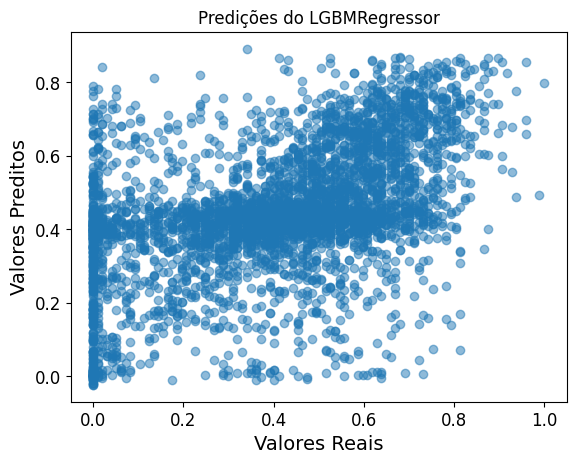

In [1221]:
# Visualizando dados: Previsão X Dados verdadeiros
plot_predictions(validation_set_cp, LightGBM_model)

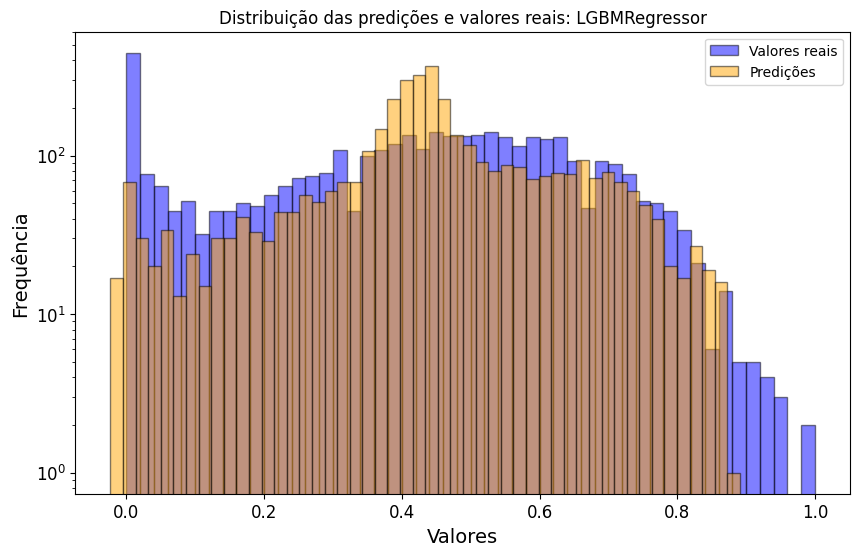

In [1222]:
plot_distribution(validation_set_cp, LightGBM_model)

### Variáveis mais significativas

In [1223]:
feature_importance(train_set_cp, LightGBM_model)

,Feature,Importance
21,artist_weighted_popularity,1.000000
11,track_year,0.728395
3,loudness,0.532922
9,valence,0.469136
8,liveness,0.430041
10,tempo,0.411523
5,speechiness,0.395062
1,energy,0.382716
0,danceability,0.380658
6,acousticness,0.360082


## **Modelo: XGBRegression**

### Treino:

In [1224]:
# Treinando modelo com conjunto de treino
XGBRegressor_model = train_model(train_set_cp, 'xgbregressor')

### Avaliação:

In [1225]:
# SEM VALIDAÇÃO CRUZADA -> Usando o conjunto de validação
evaluate_model_performance(validation_set_cp, XGBRegressor_model)

MAE: 0.17062227882542058
MSE: 0.05097576139798663
RMSE: 0.22577812426802255
R²: 0.11020186212307448
Predições do modelo: 
[0.41735148 0.6949305  0.31435028 ... 0.38446215 0.5885007  0.82089454]


In [1226]:
# COM VALIDAÇÃO CRUZADA -> Usando o conjunto de validação
cross_validation(validation_set_cp, XGBRegressor_model)

Scores: [0.22177705 0.21288086 0.20809467 0.20606245 0.20487991 0.20468015
 0.20466084 0.20463616 0.20479222 0.20497996]
Mean: 0.20774442721725134
Standard deviation: 0.005285566813026212


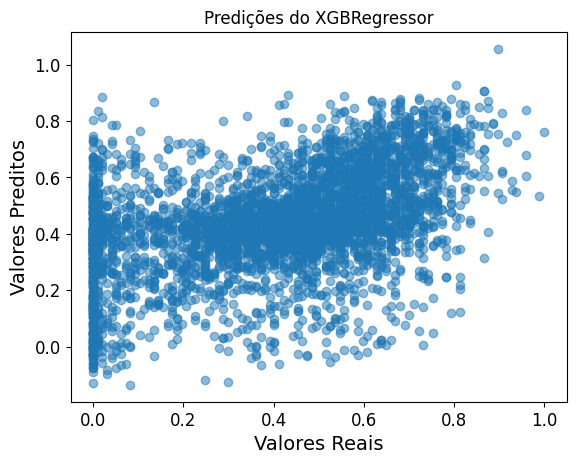

In [1227]:
# Visualizando dados: Previsão X Dados verdadeiros
plot_predictions(validation_set_cp, XGBRegressor_model)

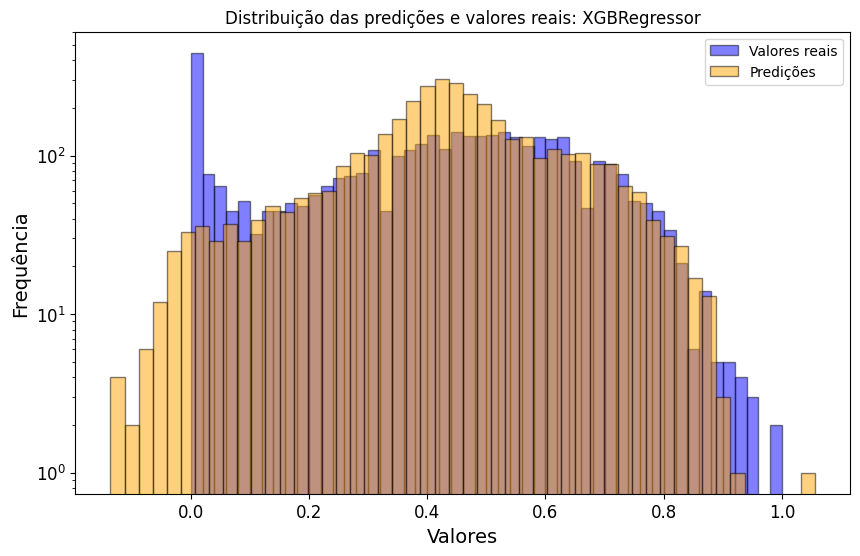

In [1228]:
plot_distribution(validation_set_cp, XGBRegressor_model)

### Variáveis mais significativas

In [1229]:
feature_importance(train_set_cp, XGBRegressor_model)

,Feature,Importance
21,track_genre_rock,1.000000
15,track_duration_classification,0.130492
17,track_genre_latin,0.060101
11,tempo,0.049897
14,track_seconds,0.031845
18,track_genre_pop,0.031543
3,key,0.030306
10,valence,0.029283
8,instrumentalness,0.029143
19,track_genre_r&b,0.028905


## **Modelo: Regressão Ridge**

### Treino:

In [1230]:

# Treinando modelo com conjunto de treino
Ridge_model = train_model(train_set_cp, 'ridge')

### Validação

In [1231]:
# SEM VALIDAÇÃO CRUZADA -> Usando o conjunto de validação
evaluate_model_performance(validation_set_cp, Ridge_model)

MAE: 0.16755195846785215
MSE: 0.05045082362268246
RMSE: 0.22461260788896614
R²: 0.11936481804873833
Predições do modelo: 
[0.41953704 0.77221843 0.42023548 ... 0.42728537 0.54537783 0.66630801]


In [1232]:
# COM VALIDAÇÃO CRUZADA -> Usando o conjunto de validação
cross_validation(validation_set_cp, Ridge_model)

Scores: [0.21849431 0.21138574 0.2129681  0.18818571 0.2082288  0.19810911
 0.20686101 0.20640093 0.21325055 0.21609909]
Mean: 0.20799833634475812
Standard deviation: 0.008566105338665425


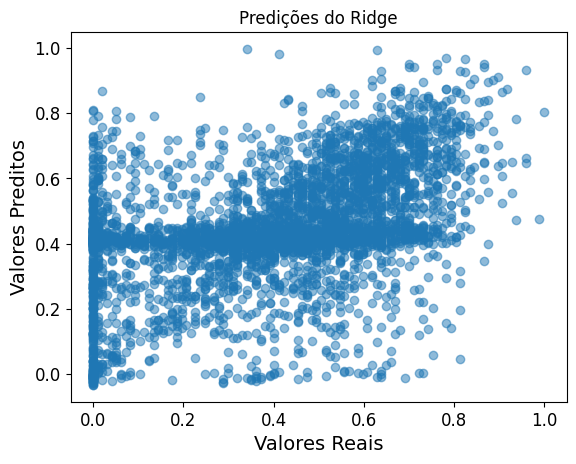

In [1233]:
# Visualizando dados: Previsão X Dados verdadeiros
plot_predictions(validation_set_cp, Ridge_model)

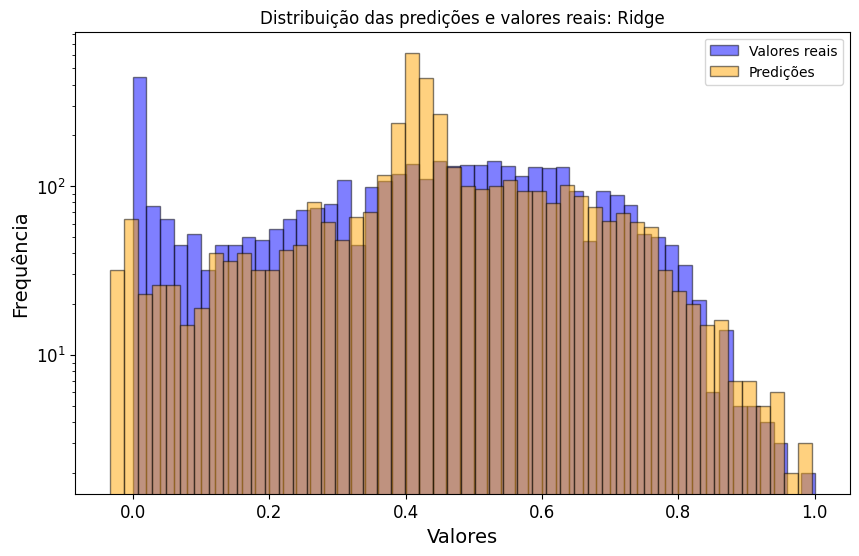

In [1234]:
plot_distribution(validation_set_cp, Ridge_model)

### Variáveis mais significativas

In [1235]:
feature_importance(train_set_cp, Ridge_model)

,Feature,Importance
21,artist_weighted_popularity,0.965708
3,loudness,0.096862
14,track_duration_classification,0.062394
1,energy,0.056798
12,track_minutes,0.037647
0,danceability,0.031293
17,track_genre_pop,0.026096
11,track_year,0.025747
15,track_genre_edm,0.016524
10,tempo,0.014093


# **ANÁLISE DE ERROS**

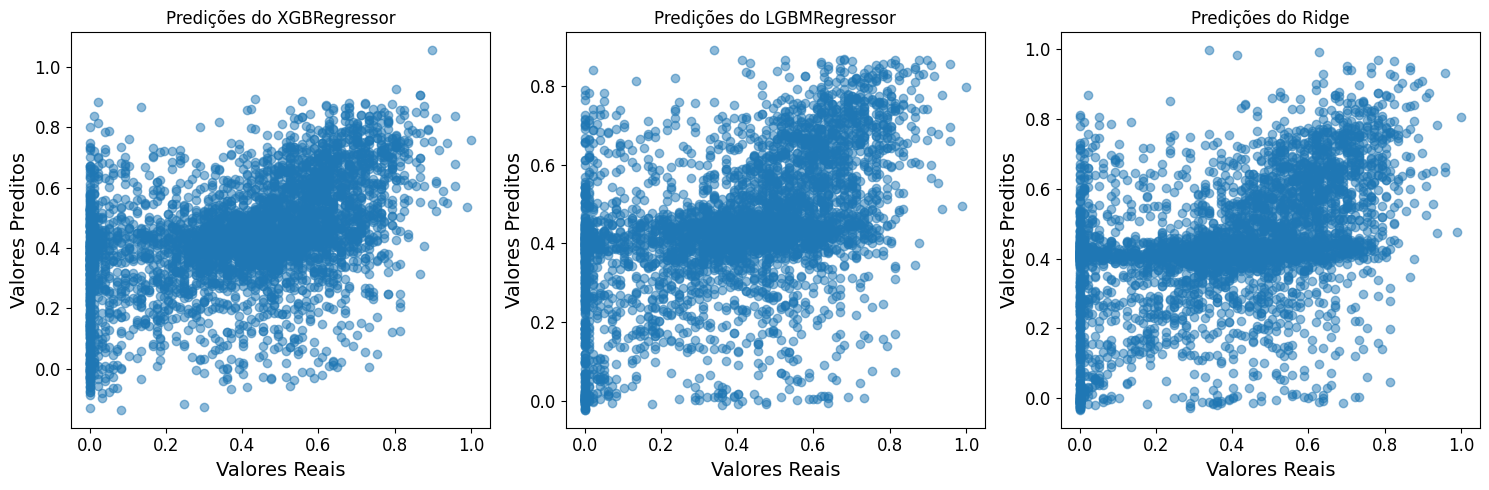

In [1236]:
# Criando a figura com 3 colunas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 linha, 3 gráficos lado a lado

# Chamando a função para cada modelo, passando os eixos correspondentes

plot_predictions(validation_set_cp, XGBRegressor_model, ax=axes[0])
plot_predictions(validation_set_cp,  LightGBM_model, ax=axes[1])
plot_predictions(validation_set_cp, Ridge_model, ax=axes[2])

plt.tight_layout()  # Ajusta os espaçamentos automaticamente
plt.show()



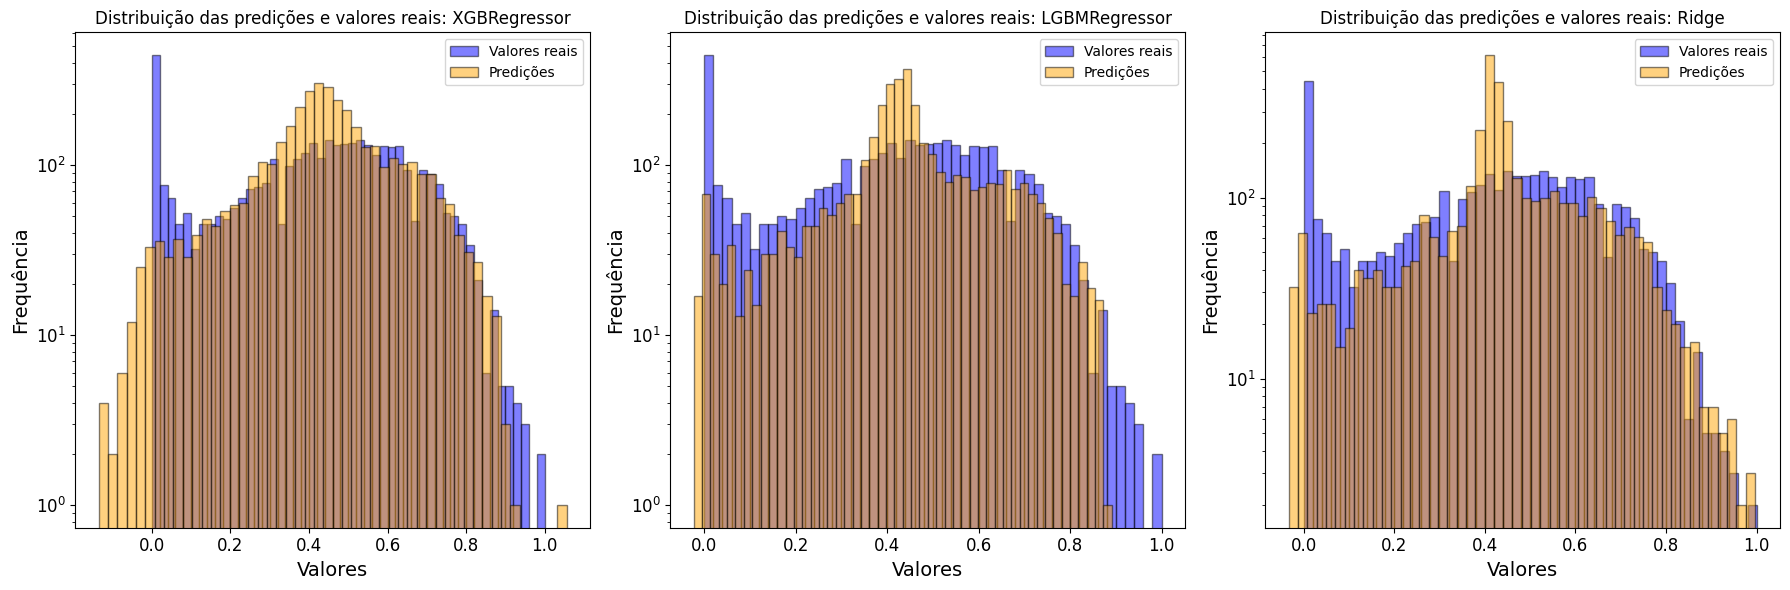

In [1237]:
# Criando a figura com 3 gráficos lado a lado
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 linha, 3 colunas

# Chamando a função para cada modelo, passando os eixos correspondentes
plot_distribution(validation_set_cp, XGBRegressor_model, ax=axes[0])
plot_distribution(validation_set_cp, LightGBM_model, ax=axes[1])
plot_distribution(validation_set_cp, Ridge_model, ax=axes[2])

plt.tight_layout()  # Ajusta os espaçamentos automaticamente
plt.show()

#### **(PERGUNTA)** Quais erros os modelos mais cometeram?  


1.  Os modelos XGBRegression, LightGBM e Ridge cometeram erros semelhantes.
2.  Nos pontos extremos(próximos de zero e próximos de 1), os 3 modelos tendem a ser menos precisos.
3.  O XGBRegression foi o modelo com piores resultados, embora ele consiga seguir a tendência geral, há muitos pontos dispersos em relação aos outros dois modelos.
4.  O XGBRegression superetimou os valores de previsão na maioria dos dados.
5.  Já o LightGBM foi melhor que o XGBRegression. Seguiu